# PS2
## Rohit Gangurde
## Collaborators : None

### Probability of predictions :

> $$ h_{\theta}(x) = \frac{1}{1 + e^{-(w.x+b)}} $$
    
> where, $ \theta$ $=$ $ [b, w_{1}, w_{2}, ... , w_{d}] $

### Sigmoid/Logistic Function :

> $$ \sigma(z) = \frac{1}{1 + e^{-z}} $$

### Maximum Likelihood Estimator

> $$ L(\theta) = P(y|X;\theta) = \prod_{i=1}^{m} P(y^{i}|x^{i};\theta) $$
>
> When, $ y = 1$, $ P(y|x;\theta)$ is $ h_{\theta}(x)$
>
> When, $ y = 0$, $ P(y|x;\theta)$ is $ 1 - h_{\theta}(x)$
>
> Therefore, $ P(y|x;\theta) = h_{\theta}(x)^{y} . (1 - h_{\theta}(x))^{1-y} $
>
> The MLE function now becomes,
>
>> $$ L(\theta) = \prod_{i=1}^{m} P(y^{i}|x^{i};\theta) = \prod_{i=1}^{m} h_{\theta}(x^{i})^{y^{i}} . (1 - h_{\theta}(x^{i}))^{1-y^{i}}  $$
>
> We take the log of the this function to simplify calculations and avoid underflow when multiplying small numbers.
>
> Hence, the log likelihood function is,
>
>> $$ log L(\theta) = \sum_{i=1}^{m} y^{i} . log[h_{\theta}(x^{i})] + (1 - y^{i}) . log(1 - h_{\theta}(x^{i})) $$

### Gradient Ascent

> Applying gradient ascent to log likelihood function,
>
>> $$ \nabla_{\theta} log L(\theta) = \nabla_{\theta} \sum_{i=1}^{m} y^{i} . log[h_{\theta}(x^{i})] + (1 - y^{i}) . log(1 - h_{\theta}(x^{i})) $$
>>
>>    $$ = \sum_{i=1}^{m} \frac{y^{i}}{h_{\theta}(x)} \nabla_{\theta} h_{\theta} (x^{i}) + \frac{1 - y^{i}}{1 - h_{\theta}(x^{i})} (-\nabla_{\theta} h_{\theta} (x^{i})) $$ 
>
> After evaluating $ \nabla_{\theta} h_{\theta}(x) $, 
>
>> $$ \nabla_{\theta} log L(\theta) = \sum_{i=1}^{m} x^{i} . (y^{i} - h_{\theta}(x^{i})) $$
>
> For faster implementation, we vectorize our calculations. 
>
>> $ w^{t} \rightarrow w^{t-1} + \eta \sum_{i=1}^{m} x^{i} . (y^{i} - h_{\theta(t-1)}(x^{i})) $ for all $j$ $\geq$ $1$
>>
> >$ b^{t} \rightarrow b^{t - 1} + \eta \sum_{i=1}^{m} (y^{i} - h_{\theta(t-1)}(x^{i})) $

### Penalizing with L2 regularization

> We add L2 regularization to avoid overfitting.
>
>> $$ Objective(\theta) = log L(\theta) - \frac{\alpha}{2} ||\theta||^{2} $$
>>
>>   $$ = log L(\theta) - \frac{\alpha}{2} \sum_{j=1}^{d} \theta_{j}^{2} $$ where $\alpha$ is the regularization weight.
>
> Hence, this changes the updates made to $w$,
>
>> $$ w \rightarrow w + \sum_{i=1}^{m} (x^{i} . (y^{i} - h_{\theta} (x^{i}))) - 2\alpha w $$
>
> We don't penalize $b$ because it doesn't grow that large.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

class l2_logistic_regression():
    """
        A logistic regression class implemented with l2 regularization and gradient ascent. The attributes of the class are :
            weights : the weight coefficients for features of the dataset
            logs : list of log likelihood estimates
            epochs : determines max iterations of the function
            learning_rate : determines by how much to step our values
            lamda_ : the regularization strength parameter for l2
    """
    def __init__(self):
        self.weights = None
        self.logs = None
        self.epochs = None
        self.learning_rate = None
        self.lambda_ = None

    def h_theta(self, x, w) :
        """
            Returns the probability of the weighted sum.
            Parameters :
                x : dataset features
                w : weight coefficients
        """
        w_x = np.dot(x, w)
        return (1 / (1 + np.exp(-w_x)))

    def log_likelihood(self, x, y, w):
        """
            Computes the log likelihood estimates.
            Parameters : 
                x : dataset features
                w : weight coefficients
                y : the target class
        """
        
        ans = 0
        for i in range(len(x)):
            preds = np.log(self.h_theta(x[i], w))
            inv_preds = np.log(1 - self.h_theta(x[i], w))
            inv_y = 1 - y[i]
            ans += y[i]*preds + inv_y*inv_preds
        return ans

    def log_derivative(self, x, errors, w, is_bias):
        """
            Computes the derivative of the l2 log likelihood function to make updates 
            to the weight coefficients
            Parameters :
                x : dataset features
                w : weight coefficients
                errors : error between predictions and true values
                is_bias : updates to weights use the L2 regularizstion parameter. For the 
                          bias coefficient, we don't use L2. So, this is a indicator for 
                          the bias coefficient.
        """
        
        derivative = np.dot(np.transpose(errors), x)
        if not is_bias :
            derivative -= 2*self.lambda_ * w
        return derivative
    
    def fit(self, X, y, epochs=100, lambda_=0.001, lr=1e-7):
        """
            Implements the fit procedure for the logistic regression model with 
            l2 regularization and gradient ascent.
            Parameters :
                X : features of the dataset
                y : target value of the dataset
                epochs : number of iterations
                lambda_ : the penalty parameter, also lambda_ = 1/c
                lr : learning rate for our function
        """
        self.epochs = epochs
        self.learning_rate = lr
        self.lambda_ = lambda_
        
        b = np.ones((X.shape[0], 1))
        X = np.hstack((b, X))
        w = np.zeros((X.shape[1], 1))
        ll = list()
        for i in range(self.epochs) :
            predictions = self.h_theta(X, w)
            errors = np.transpose(np.array([y])) - predictions
            for j in range(len(w)):
                at_bias = (j==0)
                derivative = self.log_derivative(X[:,j], errors, w[j], at_bias)
                w[j] += self.learning_rate * derivative
            ll.append(self.log_likelihood(X, y, w))
        
        self.logs = ll
        self.weights = w

    def predict(self, x_vals) :
        """
            Predict the target label
        """
        x_vals = np.array(x_vals)
        bias = np.ones((x_vals.shape[0], 1))
        x_vals = np.hstack((bias, x_vals))
        preds = list()
        for x in x_vals:
            y_hat = self.h_theta(x, self.weights)
            preds.append(y_hat)
        # Convert from probabilities to target label
        preds = np.asarray(preds).flatten() >= 0.5
        return preds
    
    def plot_likelihood(self):
        """
            Plot the likelihood estimates
        """
        x = np.linspace(0, len(self.logs), len(self.logs))
        fig = plt.figure()
        plt.plot(x, self.logs)
        fig.suptitle('Training classifier with L2')
        plt.xlabel('Epoch')
        plt.ylabel('Log Likelihood')
        plt.show()

## Estimation of paramter 'c'

In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler

features, target = load_iris(return_X_y=True)
"""
    Target classes : Iris Setosa = 0
                     Iris Versicolour = 1
                     Iris Virginica = 2
    Binary target value : Iris Setosa = 0
                          Others = 1
"""
target = [1 if y == 0 else 0 for y in target]
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.33,
                                                    random_state=42)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [3]:
C = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 1000, 10000000]

best_clf = None
best_c = 0
best_val = -1
cv = 10
y_train = np.array(y_train)
for c in C :
    avg_f1 = 0
    k_folds = StratifiedKFold(n_splits=cv, random_state=10, shuffle=True)
    clf = None
    for train_idx, val_idx in k_folds.split(x_train, y_train):
        x = x_train[train_idx]
        x_val = x_train[val_idx]
        y = y_train[train_idx]
        y_val = y_train[val_idx]
        clf = l2_logistic_regression()
        clf.fit(x, y, lambda_= 1/c, epochs=100, lr=0.001)
        y_hat_val = clf.predict(x_val)
        f1 = f1_score(y_val, y_hat_val, average='micro')
        avg_f1 += f1
        
    avg_f1 = avg_f1 / cv
    if best_val < avg_f1:
        best_val = avg_f1
        best_c = c
        best_clf = clf
    print('C : {}, f1 : {}'.format(c, avg_f1))
        
print('best C : {0}\nbest F1 : {1}'.format(best_c, best_val))

C : 0.001, f1 : 0.18000000000000005
C : 0.005, f1 : 0.6900000000000001
C : 0.01, f1 : 0.7
C : 0.05, f1 : 1.0
C : 0.1, f1 : 1.0
C : 0.5, f1 : 1.0
C : 1, f1 : 1.0
C : 5, f1 : 1.0
C : 10, f1 : 1.0
C : 50, f1 : 1.0
C : 100, f1 : 1.0
C : 500, f1 : 1.0
C : 1000, f1 : 1.0
C : 1000, f1 : 1.0
C : 10000000, f1 : 1.0
best C : 0.05
best F1 : 1.0


In [4]:
y_hat = best_clf.predict(x_test)

In [5]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       1.00      1.00      1.00        19

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



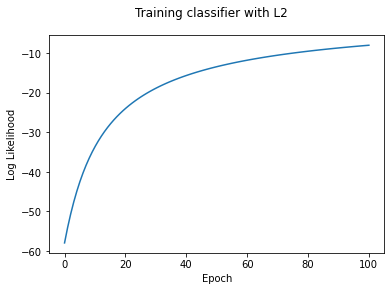

In [6]:
clf.plot_likelihood()